In [1]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from IPython.display import display
from sklearn import metrics
from scipy.cluster import hierarchy as hc
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy
import itertools

Data used in this notebook is attained from the article: "An evolutionary model to predict the frequency of antibiotic resistance under seasonal antibiotic use, and an application to Streptococcus pneumoniae" by François Blanquart, Sonja Lehtinen and Christophe Fraser.

The different antibiotics prescribed in this study are amoxicillin and amoxicillin-clavulanate (penicillin family), azithromycin (macrolide family) and cephalosporins (β-lactam family).

Here we will see which prescription is the most important descriptor of the variation of the three different antibiotics resistance. Here the method used is Random forest features importance.

In [3]:
df = pd.read_csv("assets/rspb20170679_si_005.csv")

In [4]:
df.columns = ["Year","Pencillin(R)", "Erythromycin(R)","Multidrug(R)","Amoxicillin(C)",
              "Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)","Cephalosporins(C)",
              "Azithromycin(C)","ConcTotal(C)"]

In [5]:
df.Year = pd.date_range(start='1/1/1999',end='12/1/2003',freq='MS');df = df.set_index("Year")

In [6]:
df.head(5)

,Pencillin(R),Erythromycin(R),Multidrug(R),Amoxicillin(C),Amoxicillin-Clavunate(C),Amoxicillin-Total(C),Cephalosporins(C),Azithromycin(C),ConcTotal(C)
Year,,,,,,,,,
1999-01-01,19.9071,0.00000,0.050406,222.186,67.4306,289.6166,37.6809,4.12793,358.506
1999-02-01,47.2212,2.51094,9.361640,251.312,71.1567,322.4687,25.5851,2.61499,382.361
1999-03-01,33.1068,10.22550,22.367200,161.536,51.0962,212.6322,23.9794,1.23556,256.305
1999-04-01,27.0458,10.59480,19.202200,159.751,48.1034,207.8544,25.0790,1.41010,245.790
1999-05-01,29.4490,10.48180,10.520700,163.836,47.1485,210.9845,21.0162,2.30749,244.440


In [7]:
conc = np.asarray(["Amoxicillin(C)","Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)","Cephalosporins(C)",
              "Azithromycin(C)","ConcTotal(C)"])

In [8]:
def feature_importance(X,y,name,conc=conc):
    forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking in relation to "+ str(name) + ":")

    for i, f in enumerate(range(X.shape[1])):
        print(str(i)+". {}  ({})".format(conc[indices[f]],importances[indices[f]]))
        #print("%d. feature {} (%f)" % (f + 1, conc[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importance in relation to "+ str(name) )
    plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
    plt.xticks(rotation=70)
    plt.xticks(range(X.shape[1]), conc[indices],)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [9]:
df_conc= df.drop(columns = ["Pencillin(R)", "Erythromycin(R)", "Multidrug(R)"]); X = df_conc.values

In [10]:
Pencillin,Erythromycin,Multidrug = df["Pencillin(R)"].values, df["Erythromycin(R)"].values, df["Multidrug(R)"].values

# 1. Clustering the features

Let's see how the different prescribed antibiotics correlated with each other. There seem to be redundant features in the data e.g.,  Amoxicillin-Total(C) and Amoxicillin(C) etc. Here Hierarchical clustering will be used to cluster the different prescribed antibiotics.

In [11]:
def hc_cluster(X):
    corr = np.round(scipy.stats.spearmanr(X).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=(16,10))
    dendrogram = hc.dendrogram(z, labels=conc, orientation='left', leaf_font_size=16)
    plt.show()

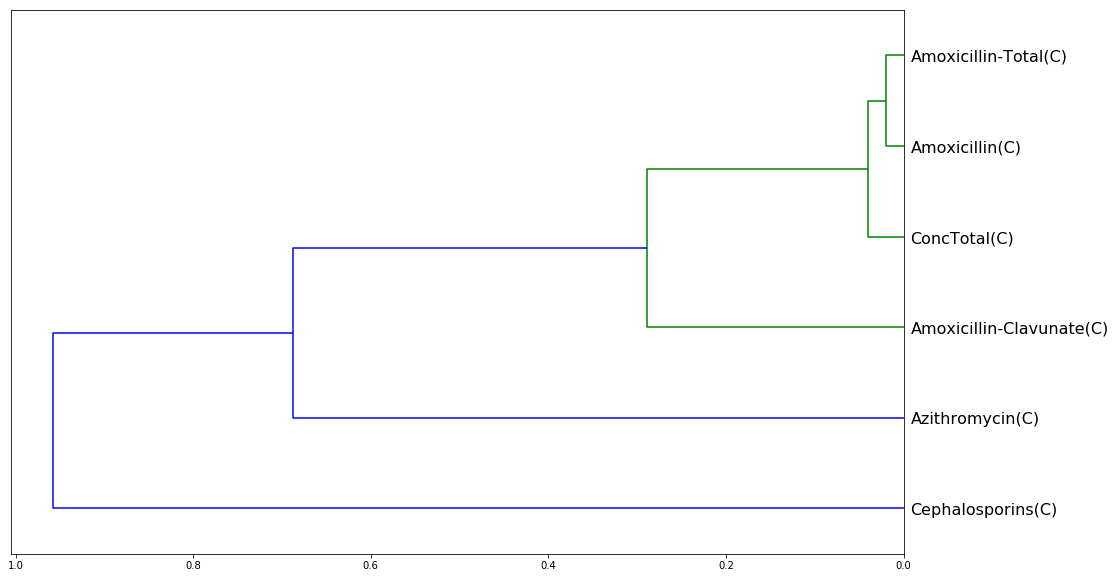

In [12]:
hc_cluster(X)

Indeed, there seems that there are three major clusters: Cephalosporins (β-lactam family), Azithromycin (macrolide family), and the Pencillins (Amoxicillin, ...).

The total antibiotic concentration i.e., ConcTotal(C) is highly correlated with the penicillins. This is probably due to the penicillin are prescribed the most.

<BarContainer object of 6 artists>

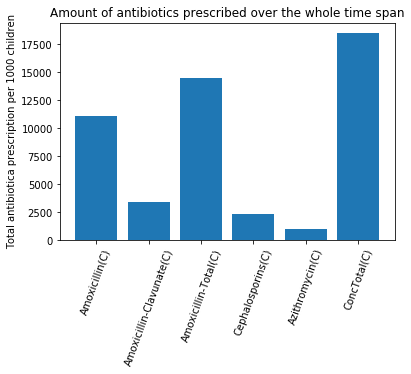

In [13]:
plt.title("Amount of antibiotics prescribed over the whole time span")
plt.xticks(rotation=70)
plt.ylabel("Total antibiotica prescription per 1000 children")
plt.bar(conc,X.sum(axis=0))

Indeed, that seems to be the case.

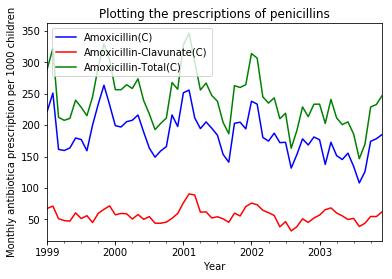

In [14]:
df["Amoxicillin(C)"].plot(c="b", title="Plotting the prescriptions of penicillins")
df["Amoxicillin-Clavunate(C)"].plot(c="r")
df["Amoxicillin-Total(C)"].plot(c="g")
plt.ylabel("Monthly antibiotica prescription per 1000 children")
plt.legend(['Amoxicillin(C)', 'Amoxicillin-Clavunate(C)',"Amoxicillin-Total(C)"], loc='upper left')
plt.show()

It seems that the prescription of Amoxicillin-Clavulanate(C) seems to follow a similar trend to the prescription of Amoxicillin(C). This would indicate that Amoxicillin-Total(C) actually would be a good indicator for both features.

Let's use one of the Pencilin features rather than use all of them to not have too much multicollinearity. Removal of multicollinearity tends to result in more further models. Firstly, let's verify the existence of multicollinearity with a VIF test.

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_conc.values, i) for i in range(df_conc.shape[1])]
vif["features"] = df_conc.columns
vif

/home/ekvall/anaconda3/envs/kth-cluster2.7/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,Amoxicillin(C)
1,inf,Amoxicillin-Clavunate(C)
2,inf,Amoxicillin-Total(C)
3,94.261600,Cephalosporins(C)
4,15.127348,Azithromycin(C)
5,5378.187125,ConcTotal(C)


Indeed, the penicillins is extremely multicollinearity, so let's drop Amoxicillin(C) and Amoxicillin-Clavunate(C), and keep Amoxicillin-Total(C). ConcTotal(C) will also be dropped since it will also be very correlating.

In [16]:
df_sub = df_conc.drop(columns=["Amoxicillin(C)","Amoxicillin-Clavunate(C)","ConcTotal(C)"])
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_sub.values, i) for i in range(df_sub.shape[1])]
vif["features"] = df_sub.columns
vif

,VIF Factor,features
0,14.740271,Amoxicillin-Total(C)
1,13.413174,Cephalosporins(C)
2,5.361120,Azithromycin(C)


This sub-dataset is much less multicollinearity and will be better for further modeling. Still, the VIF scores aren't great. A score above 5 suggests multicollinearity. Hence, this is something we need to keep in mind. Hopefully, regularizers will deal with this.

Let's see why the VIF scores are so high for Amoxicillin-Total(C) and Cephalosporins(C).

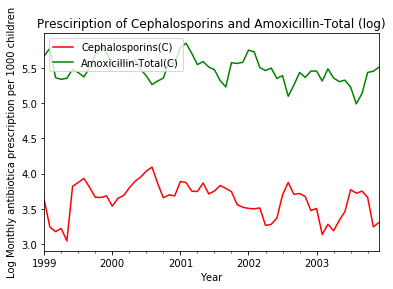

In [17]:
np.log(df["Cephalosporins(C)"]).plot(c="r", title="Presciription of Cephalosporins and Amoxicillin-Total (log)")
np.log(df["Amoxicillin-Total(C)"]).plot(c="g")
plt.legend(["Cephalosporins(C)","Amoxicillin-Total(C)"], loc='upper left')
plt.ylabel("Log Monthly antibiotica prescription per 1000 children")
plt.show()

Notice, that the log is used to make an easier comparison. One general trend is that when the prescriptions of these antibiotics are varying periodically i.e. when is at the top Cephalosporins(C) then Amoxicillin-Total(C) is at is lowest, and vice versa.

Now we randomly dropped two penicillins features. There's perhaps smarter to check which feature that is more important for each antibiotic resistance.

# 2. Pencillin resistance feature importance

Lets start to see what feature is the most important of the pencilin resistance.

Feature ranking in relation to Pencillin:
0. Cephalosporins(C)  (0.285152689209)
1. Amoxicillin-Total(C)  (0.164802425408)
2. Amoxicillin(C)  (0.15514247645)
3. ConcTotal(C)  (0.151452159888)
4. Amoxicillin-Clavunate(C)  (0.127653221764)
5. Azithromycin(C)  (0.11579702728)


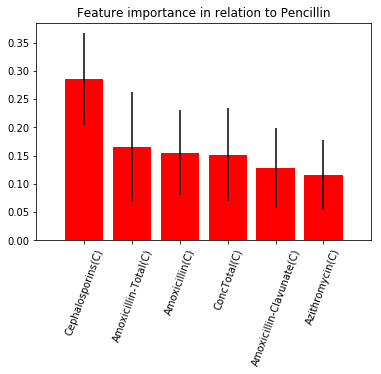

In [18]:
feature_importance(X,Pencillin,"Pencillin")

Here it seems that Cephalosporins is the most important feature for penicillin resistance, as opposed to penicillin prescription. This must be that the increase of prescriptions of other antibiotics than penicillin leads to a decrease of penicillin resistance.

In [19]:
pec_df = df.drop(columns=["Erythromycin(R)", "Multidrug(R)"]); pec_df.corr()['Pencillin(R)'][:]

Pencillin(R)                1.000000
Amoxicillin(C)              0.214159
Amoxicillin-Clavunate(C)    0.252941
Amoxicillin-Total(C)        0.237861
Cephalosporins(C)          -0.404756
Azithromycin(C)             0.013130
ConcTotal(C)                0.136408
Name: Pencillin(R), dtype: float64

Indeed, Cephalosporins negatively correlates with penicillin resistance. This is in accordance with François Blanquart e.al. that found the prescription of Cephalosporins had the most negative effect on the penicillin resistance. Let's use one of the Pencilin features rather than use all of them to not have too much multicollinearity. Removal of multicollinearity tends to result in more further models. 

Since ConcTotal(C) consider all antibiotics this should not be used as a placeholder for penicillin, even though it penicillin is the largest contributor to that features.

Feature ranking in relation to Pencillin:
0. Cephalosporins(C)  (0.421491407242)
1. Amoxicillin-Total(C)  (0.348379546466)
2. Azithromycin(C)  (0.230129046292)


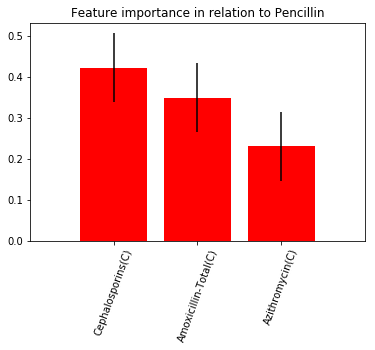

Feature ranking in relation to Pencillin:
0. Cephalosporins(C)  (0.422484880088)
1. Amoxicillin-Clavunate(C)  (0.297540629803)
2. Azithromycin(C)  (0.27997449011)


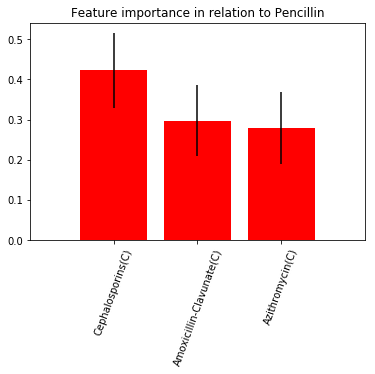

Feature ranking in relation to Pencillin:
0. Cephalosporins(C)  (0.428755502282)
1. Amoxicillin(C)  (0.331957397538)
2. Azithromycin(C)  (0.23928710018)


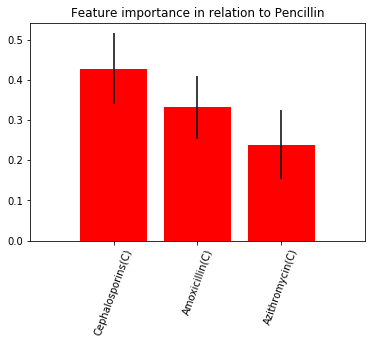

In [20]:
for feat in itertools.combinations(["Amoxicillin(C)","Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)"], 2):
    X_t = df_conc.drop(columns=[feat[0],feat[1],"ConcTotal(C)"])
    feature_importance(X_t.values,Pencillin,"Pencillin",conc=X_t.columns.values)


Amoxicillin-Clavulanate(C) seems not to be as important as Amoxicillin(C). This is probably due to the fact that the amount of prescriptions Amoxicillin far outnumbers Amoxicillin-Clavulanate.

# 3. Erythromycin resistance feature importance

Feature ranking in relation to Erythromycin:
0. Azithromycin(C)  (0.343057503258)
1. Amoxicillin(C)  (0.151430231685)
2. ConcTotal(C)  (0.141330490256)
3. Amoxicillin-Total(C)  (0.132970599408)
4. Cephalosporins(C)  (0.130833821506)
5. Amoxicillin-Clavunate(C)  (0.100377353887)


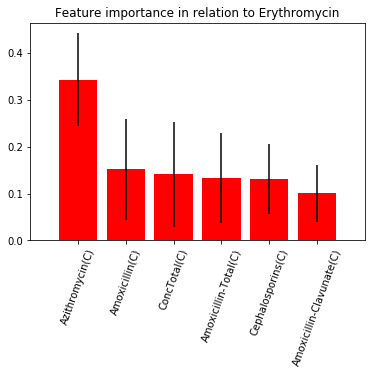

In [21]:
feature_importance(X,Erythromycin,"Erythromycin")

Azithromycin is an important feature for Erythromycin resistance, similar to the authors. Let's how the penicillin is important when only using one representative.

Feature ranking in relation to Erythromycin:
0. Azithromycin(C)  (0.455800700444)
1. Amoxicillin-Total(C)  (0.285516793955)
2. Cephalosporins(C)  (0.258682505601)


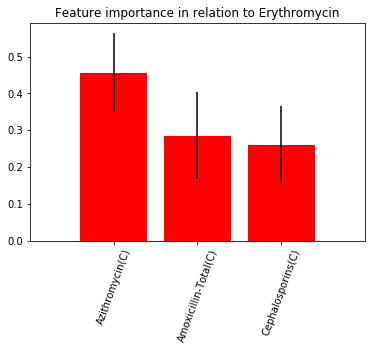

Feature ranking in relation to Erythromycin:
0. Azithromycin(C)  (0.460811969943)
1. Cephalosporins(C)  (0.298242511254)
2. Amoxicillin-Clavunate(C)  (0.240945518804)


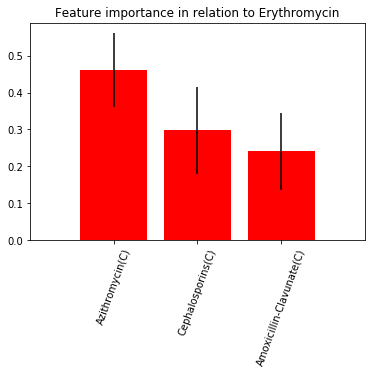

Feature ranking in relation to Erythromycin:
0. Azithromycin(C)  (0.433143965482)
1. Amoxicillin(C)  (0.335782257513)
2. Cephalosporins(C)  (0.231073777005)


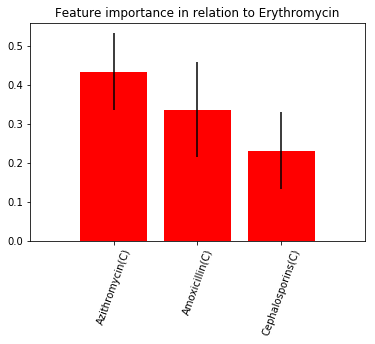

In [22]:
for feat in itertools.combinations(["Amoxicillin(C)","Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)"], 2):
    X_t = df_conc.drop(columns=[feat[0],feat[1],"ConcTotal(C)"])
    feature_importance(X_t.values,Erythromycin,"Erythromycin",conc=X_t.columns.values)

It seems that Amoxicillin-Clavunate(C) is the worst descriptor of Erythromycin resistance. The authors said that Amoxicillin did not select for Erythromycin resistance. They could have found that it selected against Erythromycin resistance, but they did not mention it. In either case, here it seems at least to be important enough consider.

# Multidrug resistance feature importance

Feature ranking in relation to Multidrug:
0. Azithromycin(C)  (0.279222997057)
1. Amoxicillin(C)  (0.16436975406)
2. Cephalosporins(C)  (0.143729704895)
3. ConcTotal(C)  (0.142385768816)
4. Amoxicillin-Total(C)  (0.135585334262)
5. Amoxicillin-Clavunate(C)  (0.134706440909)


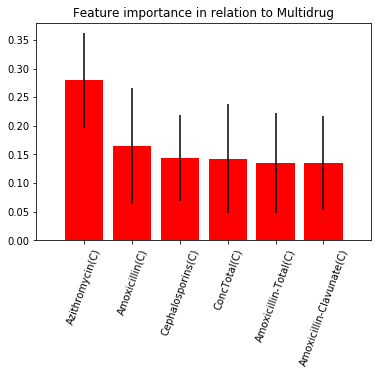

In [23]:
feature_importance(X,Multidrug,"Multidrug")

Here Azithromycin is the most impostant features, similar to the authors finding.

Feature ranking in relation to Multidrug:
0. Azithromycin(C)  (0.403036927237)
1. Amoxicillin-Total(C)  (0.315043755714)
2. Cephalosporins(C)  (0.281919317049)


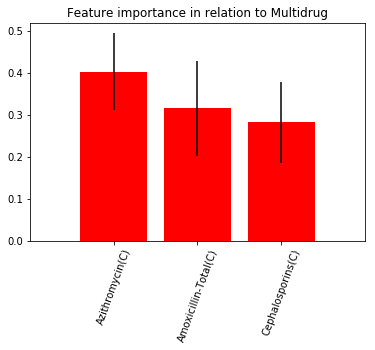

Feature ranking in relation to Multidrug:
0. Azithromycin(C)  (0.394512626513)
1. Amoxicillin-Clavunate(C)  (0.307492923919)
2. Cephalosporins(C)  (0.297994449569)


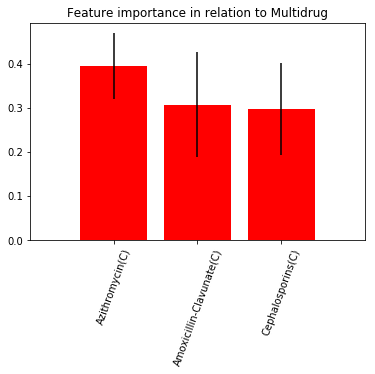

Feature ranking in relation to Multidrug:
0. Azithromycin(C)  (0.407698589687)
1. Amoxicillin(C)  (0.339343347946)
2. Cephalosporins(C)  (0.252958062367)


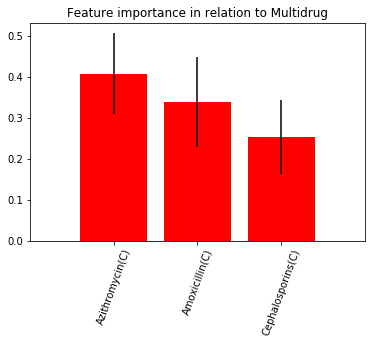

In [24]:
for feat in itertools.combinations(["Amoxicillin(C)","Amoxicillin-Clavunate(C)","Amoxicillin-Total(C)"], 2):
    X_t = df_conc.drop(columns=[feat[0],feat[1],"ConcTotal(C)"])
    feature_importance(X_t.values,Multidrug,"Multidrug",conc=X_t.columns.values)